# Beacon Sync

Synchronise two delta peaks, by using an intermediate beacon that was sent out together with it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import os
import sys
# Append parent directory to import path so lib can be found
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from lib.util import *
from lib.plotting import *
from lib.timing import *


In [2]:
us = 1e3 # ns
ns = 1/us # us


band = (30, 80) # MHz
samplerate = 500 # MHz
timelength = 0.2 # us

time = np.arange(0, timelength, 1/samplerate)

# generate beacons
if True: # in-band
    f_beacon = 70 # MHz
else: # under band
    f_beacon = 20 # MHz

beacon_amplitude = 0.1
beacon_init_phase = time2phase(4.4*ns, f_beacon)
beacon_phase_offset = 1.2*np.pi

beacons = np.array([
    beacon_amplitude * sin_delay(f_beacon, time, t_delay=0, phase=-beacon_init_phase),
    beacon_amplitude * sin_delay(f_beacon, time, t_delay=0, phase=-beacon_init_phase-beacon_phase_offset)
])


# generate impulses
impulses = []
impulses_offsets = []
impulses_def_offsets = [
                        (0.3*len(time),0.4*len(time)),
                        (0.5*len(time),0.9*len(time)),
                       ]# random offsets in interval
if True:
    # freeze impulses
    impulses_def_offsets = [
        0.064*samplerate,
        0.178*samplerate        
    ]
if not True:
    # Equal offset to beacon and 
    impulses_def_offsets = [
        64*ns*samplerate,
        (64*ns + (beacon_phase_offset % (2*np.pi))/(2*np.pi*f_beacon) + 6/f_beacon)*samplerate
    ]
    if True:
        impulses_def_offsets = [impulses_def_offsets[0]]
        
    
for i in range(2):
    offset = None
    if impulses_def_offsets:
        if len(impulses_def_offsets) == 1:
            offset = impulses_def_offsets[0]
        else:
            offset = impulses_def_offsets[i]
    orig_imp, imp_offset = deltapeak(timelength, samplerate, offset=offset, peaklength=1)

    orig_imp[imp_offset] = 0.1
    ## Bandpass it
    imp, _ = fft_bandpass(orig_imp, band, samplerate)
    imp /= np.max(imp)
    
    impulses.append(imp)
    impulses_offsets.append(imp_offset/samplerate)

impulses = np.array(impulses)
impulses_offsets = np.array(impulses_offsets)
print("Beacon period [ns]:", 1/f_beacon/ns)
print("Beacon initial [ns]:", phase2time(beacon_init_phase, f_beacon) /ns)
print("Beacon initial [phase]:", beacon_init_phase)
print("Beacon initial [idx]:", phase2time(beacon_init_phase, f_beacon)*samplerate)
print("Beacon difference [ns]:", phase2time(beacon_phase_offset, f_beacon)/ns)
print("Beacon difference [phase]:", beacon_phase_offset)
print("Impulse offsets [ns]:", impulses_offsets[:,0]/ns)
print("Time difference Impulses [ns]: {}".format( (impulses_offsets[1,0]-impulses_offsets[0,0])/ns ))
print("Time difference Impulses [T]: {}".format( (impulses_offsets[1,0]-impulses_offsets[0,0])*f_beacon ))

Beacon period [ns]: 14.285714285714285
Beacon initial [ns]: 4.4
Beacon initial [phase]: 1.9352210746113125
Beacon initial [idx]: 2.2
Beacon difference [ns]: 8.571428571428571
Beacon difference [phase]: 3.7699111843077517
Impulse offsets [ns]: [ 64. 178.]
Time difference Impulses [ns]: 113.99999999999999
Time difference Impulses [T]: 7.9799999999999995


In [3]:
full_signals = impulses + beacons

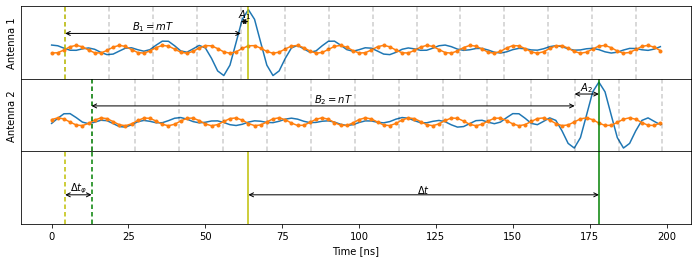

In [15]:
# Make a figure showing two signals with a beacon per signal
colors = ['y','g']
multiplier_name = ['m','n']


fig, axes = plt.subplots(3,1, sharex=True, figsize=(12,4), gridspec_kw=dict(hspace=0))
for i, ax in enumerate(axes):
    #if i != 0:
    #    ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #if i != len(axes)-1:
    #    ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    pass

axes[-1].set_xlabel("Time [ns]")
axes[-1].set_yticks([],[])
for i in range(0, 2):
    axes[i].set_yticks([],[])
    axes[i].set_ylabel("Antenna {:d}".format(i+1))
    axes[i].plot(time/ns, impulses[i])
    axes[i].plot(time/ns, beacons[i], marker='.')
    if not True:
        axes[i].plot(time/ns, full_signals[i])


# indicate timing of pulses
for i, impulse_offset in enumerate(impulses_offsets):
    kwargs = dict(color=colors[i])
    [ax.axvline(impulse_offset/ns, **kwargs) for ax in (axes[i], axes[-1])]


# indicate timing of the beacons
# and annotate ticks and impulse widths
tmp_beacon_phases = beacon_init_phase + np.arange(0,2)*beacon_phase_offset
if True: # mod phases
    tmp_beacon_phases %= 2*np.pi
tmp_beacon_offsets = phase2time(tmp_beacon_phases, f_beacon)


A = np.empty(2)
B = np.empty(2)
for i in range(0,2):
    kwargs = dict(color=colors[i], ls=(0, (3,2)))
    tick_kwargs = dict(color='k', alpha=0.2)

    # indicate every period of the beacon
    beacon_ticks =  tmp_beacon_offsets[i] + [(n)*1/f_beacon for n in range(1+int((time[-1] - time[0]) * f_beacon))]

    [axes[i].axvline(tick/ns, **{**kwargs, **tick_kwargs}) for tick in beacon_ticks]

    # reference period in beacon
    [ax.axvline(tmp_beacon_offsets[i]/ns, **kwargs) for ax in (axes[i], axes[-1])]

    # annotate width between impulse and closest beacon tick
    # and closest beacon tick and reference tick
    closest_beacon_tick_id = np.argmin(np.abs(beacon_ticks-impulses_offsets[i]))
    if closest_beacon_tick_id != 0 and beacon_ticks[closest_beacon_tick_id] > impulses_offsets[i]:
        closest_beacon_tick_id -= 1
    closest_beacon_tick = beacon_ticks[closest_beacon_tick_id]

    annotate_width(axes[i], f"$A_{i+1}$", closest_beacon_tick/ns, impulses_offsets[i]/ns, 0.7)
    annotate_width(axes[i], f"$B_{i+1}={multiplier_name[i]}T$", closest_beacon_tick/ns, tmp_beacon_offsets[i]/ns, 0.4)

    A[i] = closest_beacon_tick - impulses_offsets[i]
    B[i] = closest_beacon_tick - tmp_beacon_offsets[i]

# annotate width between beacon reference periods
annotate_width(axes[-1], "$\Delta t_\\varphi$", tmp_beacon_offsets[0]/ns, tmp_beacon_offsets[-1]/ns, 0.4)

# annotate width between pulses
annotate_width(axes[-1], "$\Delta t$", impulses_offsets[0]/ns, impulses_offsets[-1]/ns, 0.4)


fig.show()
if True:
    fname = 'figures/08_beacon_sync_timing_outline'

    # Dump figure
    fig.savefig(fname +'.pdf')
    
    # Dump information into accompanying file
    with open(fname + '.dat', 'w+') as fp:
        fp.write("f_beacon = {}MHz\n".format(f_beacon))
        fp.write("samplerate = {}\n".format(samplerate))
        fp.write("band = {}MHz\n".format(band))
        fp.write("timelength = {}us\n".format(timelength))
        
        fp.write("-"*8 + "\n")
        fp.write("\Delta t = {}ns\n".format( (impulses_offsets[1][0] - impulses_offsets[0][0])/ns ))
        fp.write("t_phi = {}ns\n".format( (tmp_beacon_offsets[1]-tmp_beacon_offsets[0])/ns ))
        fp.write("\Delta A = {}ns\n".format( (A[1] - A[0])/ns ))
        fp.write("kT = {}ns = {}T\n".format( (B[1]-B[0])/ns, (B[1]-B[0])*f_beacon ))
        
        fp.write("-"*8 + "\n")
        fp.write("A_1 = {}ns\n".format( (A[0])/ns ))
        fp.write("A_2 = {}ns\n".format( (A[1])/ns ))
        fp.write("B_1 = {}ns = {}T\n".format( (B[0])/ns, (B[0]*f_beacon) ))
        fp.write("B_2 = {}ns = {}T\n".format( (B[1])/ns, (B[1]*f_beacon) ))

In [5]:
t_phi = (tmp_beacon_offsets[1]-tmp_beacon_offsets[0])
Delta_A = (A[1] - A[0])

print("\Delta t = {}ns".format( (impulses_offsets[1][0] - impulses_offsets[0][0])/ns ))
print("\Delta A = {}ns".format( Delta_A/ns ))
print("t_phi = {}ns".format( t_phi/ns ))
print("B_1 = {}ns = {}T".format( (B[0])/ns, (B[0]*f_beacon) ))
print("B_2 = {}ns = {}T".format( (B[1])/ns, (B[1]*f_beacon) ))
print("kT = {}ns = {}T".format( (B[1]-B[0])/ns, (B[1]-B[0])*f_beacon ))



\Delta t = 113.99999999999999ns
\Delta A = -5.428571428571415ns
t_phi = 8.571428571428573ns
B_1 = 57.14285714285714ns = 4.0T
B_2 = 157.14285714285714ns = 11.0T
kT = 100.0ns = 7.0T


$
\Delta t = (A_2 + B_2) - (A_1 + B_1) + t_\phi\\
\quad         = (A_2 - A_1) + (B_2 - B_1) + t_\phi\\
\quad         = (A_2 - A_1) + (nT - mT) + t_\phi\\
\quad         = \Delta A + t_\phi + (kT) 
$

, where $\Delta A < T$ and $k \in \mathbb{Z}$ and $t_\phi$ is minimisable by synchronising the beacons.

Then $\Delta t$ can be determined by iteratively summing the signals, changing $k$, and finding the $k$ belonging to the maximum of the sums.

Best k: 7
Maximum: 2.0


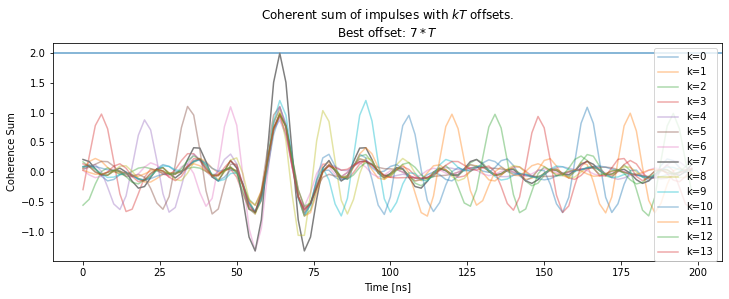

In [6]:
# Make figure showing the sums depending on k
ref_impulse = impulses[0]
my_impulse = impulses[1]

# remove 'already determined' offsets
if True:
    # $t_\phi$ offset
    my_impulse = time_roll(my_impulse, samplerate, -t_phi)

if True:
    # $\Delta A$ offset
    my_impulse = time_roll(my_impulse, samplerate, +Delta_A)

best_k, (ks, maxima) = beacon_integer_period(samplerate, f_beacon, ref_impulse, my_impulse)
print("Best k: {:0g}".format(best_k))
print("Maximum: {}".format(maxima[np.where(ks == best_k)][0]))


# Make figure
fig, axes = plt.subplots(1, 1, sharex=True,figsize=(12,4))
if not hasattr(axes, 'ndim'):
    axes = [axes]

axes[0].set_title("Coherent sum of impulses with $kT$ offsets.\nBest offset: ${:.0f}*T$".format(best_k))
axes[-1].set_xlabel("Time [ns]")

if not True:
    i=0
    axes[i].set_ylabel("Reference")
    axes[i].plot(time/ns, ref_impulse, label="reference")
    axes[i].plot(time/ns, my_impulse, label='impulse')
    axes[i].legend()

axes[-1].set_ylabel("Coherence Sum")

best_maximum = np.max(maxima)
axes[-1].axhline(best_maximum, alpha=0.7)

for i, k in enumerate(ks, 0):
        sample_offset = int(k*1/f_beacon*samplerate)
        augmented_impulses = np.roll(my_impulse, sample_offset)
        
        summed_impulse = ref_impulse + augmented_impulses
        if True or k%2 == 1:
            axes[-1].plot(time/ns, summed_impulse, label='k={:.0f}'.format(k),
                         alpha=0.1 + 0.9*1/(1+2*abs(best_maximum-maxima[i]))
                        )
    
axes[-1].legend()
fig.show()

if True:
    fname = 'figures/08_beacon_sync_coherent_sum'

    # Dump figure
    fig.savefig(fname +'.pdf')

del ref_impulse
del my_impulse

## 1. Solve it

 1. Find $t_\phi$
 2. Find $\Delta A$
 3. Find $kT$

#####  1.1 Beacon Phase Delay ($t_\phi$)

In [7]:
abs_beacon_time_delays_tmp = np.array([
    beacon_time_delay(samplerate, beacons[0], beacon)
        for beacon in beacons
])


abs_beacon_time_delays = abs_beacon_time_delays_tmp[:,0]
t_phi = np.array(abs_beacon_time_delays % (1/f_beacon), dtype=np.float64)
beacon_time_delays_err = abs_beacon_time_delays_tmp[:,1]

print("Beacon delays [ns] \pm k*{}ns: {}".format(1/f_beacon/ns, t_phi/ns))

Beacon delays [ns] \pm k*14.285714285714285ns: [0.         8.57142857]


/tmp/ipykernel_1809896/665080263.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  abs_beacon_time_delays_tmp = np.array([


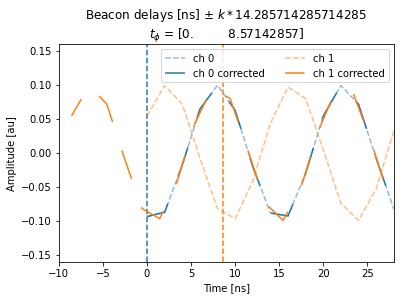

In [8]:
# Make a figure showing the corrected beacons
fig, ax = plt.subplots(1,1, sharex=True)
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Amplitude [au]")
ax.set_title(
    "Beacon delays [ns] $\pm$ $k*{}$\n$t_{{\phi}}$ = {}"
    .format(1/f_beacon/ns, t_phi/ns)
)

for i, _ in enumerate(beacons):
    l = ax.plot(
                time/ns, beacons[i],
                label="ch {}".format(i), 
                ls ='--', 
                alpha=0.5
    )
    
    # indicate start of uncorrected beacons
    ax.axvline(
        t_phi[i]/ns,
        color=l[0].get_color(),
        ls = '--'
    )
    
    ax.plot(
            (time-t_phi[i])/ns,
            beacons[i],
            label='ch {} corrected'.format(i),
            color=l[0].get_color(),
            ls=(5*i+2, (20, 20))
    )
    
ax.legend(ncol=2)
ax.margins(y=0.3)
if True:
    ax.set_xlim(time[0]/ns - 10, time[2*samplerate//f_beacon]/ns)

fig.show()

##### 1.1.2 Beacon Synced traces

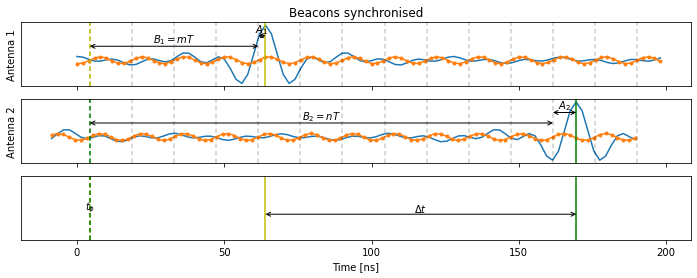

In [9]:
fig, axes = beacon_sync_figure(
    time, impulses, beacons,
    delta_t = t_phi,
    beacon_offsets = phase2time(beacon_init_phase, f_beacon) + t_phi,
    impulse_offsets = impulses_offsets,
    f_beacon = f_beacon,
    show_annotations = True
)
axes[0].set_title("Beacons synchronised")
fig.show()

if True:
    fname = 'figures/08_beacon_sync_synchronised_outline'

    # Dump figure
    fig.savefig(fname +'.pdf')

##### 1.2 Impulse delays ($\Delta A, kT$)

###### 1.2.1 $\Delta A$
Find the delay within a single beacon period

In [10]:
impulse_max_time = np.argmax(impulses, axis=1) /samplerate
impulse_time_in_periods = np.array((impulse_max_time - t_phi)*f_beacon)
someB, A = np.divmod(impulse_time_in_periods, 1)

# subtract the reference beacon's value to obtain time differences
A -= A[0]
someB -= someB[0]

Delta_A = A[1:] - A[0]
print(someB)

[0. 7.]


###### 1.2.2 $kT$
Find integer number of periods

In [11]:
ref_impulse = impulses[0]
my_impulse = impulses[1]

# remove 'already determined' offsets
if True:
    # $t_\phi$ offset
    my_impulse = time_roll(my_impulse, samplerate, -t_phi)

if True:
    # $\Delta A$ offset
    my_impulse = time_roll(my_impulse, samplerate, +Delta_A)

best_k, (ks, maxima) = beacon_integer_period(samplerate, f_beacon, ref_impulse, my_impulse)
print("Best k: {:0g}".format(best_k))
print("Maximum: {}".format(maxima[np.where(ks == best_k)][0]))
B = np.array([ 0, best_k])


Best k: 8
Maximum: 2.0


#### 1.3 Total Time delay

In [12]:
print("Δ𝐴 = {}".format(A /f_beacon/ns))
print("B = kT = {}T".format(B))
print("𝑡𝜙 = {}".format(t_phi/ns))


delta_t = A/f_beacon + B/f_beacon + t_phi

print("Δt = {}".format(delta_t[1]))

print("Preset Δt = {}".format(impulses_offsets[1,0]-impulses_offsets[0,0]))

Δ𝐴 = [0.         5.42857143]
B = kT = [0 8]T
𝑡𝜙 = [0.         8.57142857]
Δt = 0.12828571428571425
Preset Δt = 0.11399999999999999


##### 1.3.2 Beacon Synced and Period Alignment

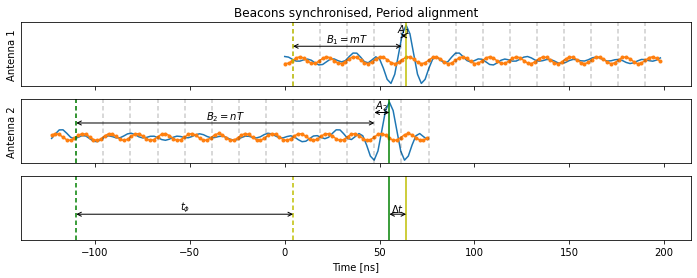

In [13]:
fig, axes = beacon_sync_figure(
    time, impulses, beacons,
    delta_t = (B + [0,-0])/f_beacon + t_phi,
    beacon_offsets = phase2time(beacon_init_phase, f_beacon) + t_phi,
    impulse_offsets = impulses_offsets,
    f_beacon = f_beacon,
    show_annotations = True
)
axes[0].set_title("Beacons synchronised, Period alignment")
fig.show()
if True:
    fname = 'figures/08_beacon_sync_synchronised_period_alignment'

    # Dump figure
    fig.savefig(fname +'.pdf')